Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Custom Raster Datasets

In this tutorial, we'll describe how to write a custom dataset in TorchGeo. There are many types of datasets that you may encounter, from image data, to segmentation masks, to point labels. We'll focus on the most common type of dataset: a raster file containing an image or mask. Let's get started!

## Choosing a base class

In TorchGeo, there are two _types_ of datasets:

* `GeoDataset`: for uncurated raw data with geospatial metadata
* `NonGeoDataset`: for curated benchmark datasets that lack geospatial metadata

If you're not sure which type of dataset you need, a good rule of thumb is to run `gdalinfo` on one of the files. If `gdalinfo` returns information like the bounding box, resolution, and CRS of the file, then you should probably use `GeoDataset`.

### GeoDataset

In TorchGeo, each `GeoDataset` uses an [R-tree](https://en.wikipedia.org/wiki/R-tree) to store the spatiotemporal bounding box of each file or data point. To simplify this process and reduce code duplication, we provide two subclasses of `GeoDataset`:

* `RasterDataset`: recursively search for raster files in a directory
* `VectorDataset`: recursively search for vector files in a directory

In this example, we'll be working with raster images, so we'll choose `RasterDataset` as the base class.

### NonGeoDataset

`NonGeoDataset` is almost identical to [torchvision](https://pytorch.org/vision/stable/index.html)'s `VisionDataset`, so we'll instead focus on `GeoDataset` in this tutorial. If you need to add a `NonGeoDataset`, the following tutorials may be helpful:

* [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
* [Writing Custom Datasets, DataLoaders and Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* [Developing Custom PyTorch DataLoaders](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html)

Of course, you can always look for similar datasets that already exist in TorchGeo and copy their design when creating your own dataset.

## Setup

First, we install TorchGeo and a couple of other dependencies for downloading data from Microsoft's Planetary Computer.

In [1]:
%pip install torchgeo planetary_computer pystac

## Imports

Next, we import TorchGeo and any other libraries we need.

In [2]:
import os
import tempfile
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)

## Downloading

Let's download some data to play around with. In this example, we'll create a dataset for loading Sentinel-2 images. Yes, TorchGeo already has a built-in class for this, but we'll use it as an example of the steps you would need to take to add a dataset that isn't yet available in TorchGeo. We'll show how to download a few bands of Sentinel-2 imagery from the Planetary Computer. This may take a few minutes.

In [3]:
root = tempfile.mkdtemp()
item_urls = [
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220902T090559_R050_T40XDH_20220902T181115",
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220718T084609_R107_T40XEJ_20220718T175008",
]

for item_url in item_urls:
    item = pystac.Item.from_file(item_url)
    signed_item = planetary_computer.sign(item)
    for band in ["B02", "B03", "B04", "B08"]:
        asset_href = signed_item.assets[band].href
        filename = urlparse(asset_href).path.split("/")[-1]
        download_url(asset_href, root, filename)

  0%|          | 0/197389773 [00:00<?, ?it/s]

  0%|          | 0/192099728 [00:00<?, ?it/s]

  0%|          | 0/186117847 [00:00<?, ?it/s]

  0%|          | 0/185748811 [00:00<?, ?it/s]

  0%|          | 0/198106313 [00:00<?, ?it/s]

  0%|          | 0/195789388 [00:00<?, ?it/s]

  0%|          | 0/193846206 [00:00<?, ?it/s]

  0%|          | 0/200519427 [00:00<?, ?it/s]

This downloads the following files:

In [4]:
sorted(os.listdir(root))

['T40XDH_20220902T090559_B02_10m.tif',
 'T40XDH_20220902T090559_B03_10m.tif',
 'T40XDH_20220902T090559_B04_10m.tif',
 'T40XDH_20220902T090559_B08_10m.tif',
 'T40XEJ_20220718T084609_B02_10m.tif',
 'T40XEJ_20220718T084609_B03_10m.tif',
 'T40XEJ_20220718T084609_B04_10m.tif',
 'T40XEJ_20220718T084609_B08_10m.tif']

As you can see, each spectral band is stored in a different file. We have downloaded 2 total scenes, each with 4 spectral bands.

## Defining a dataset

To define a new dataset class, we subclass from `RasterDataset`. `RasterDataset` has several class attributes used to customize how to find and load files.

### `filename_glob`

In order to search for files that belong in a dataset, we need to know what the filenames look like. In our Sentinel-2 example, all files start with a capital `T` and end with `_10m.tif`. We also want to make sure that the glob only finds a single file for each scene, so we'll include `B02` in the glob. If you've never used Unix globs before, see Python's [fnmatch](https://docs.python.org/3/library/fnmatch.html) module for documentation on allowed characters.

### `filename_regex`

Rasterio can read the geospatial bounding box of each file, but it can't read the timestamp. In order to determine the timestamp of the file, we'll define a `filename_regex` with a group labeled "date". If your files don't have a timestamp in the filename, you can skip this step. If you've never used regular expressions before, see Python's [re](https://docs.python.org/3/library/re.html) module for documentation on allowed characters.

### `date_format`

The timestamp can come in many formats. In our example, we have the following format:

* 4 digit year (`%Y`)
* 2 digit month (`%m`)
* 2 digit day (`%d`)
* the letter T
* 2 digit hour (`%H`)
* 2 digit minute (`%M`)
* 2 digit second (`%S`)

We'll define the `date_format` variable using [datetime format codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes).

### `is_image`

If your data only contains image files, as is the case with Sentinel-2, use `is_image = True`. If your data only contains segmentation masks, use `is_image = False` instead.

### `separate_files`

If your data comes with each spectral band in a separate files, as is the case with Sentinel-2, use `separate_files = True`. If all spectral bands are stored in a single file, use `separate_files = False` instead.

### `all_bands`

If your data is a multispectral image, you can define a list of all band names using the `all_bands` variable.

### `rgb_bands`

If your data is a multispectral iamge, you can define which bands correspond to the red, green, and blue channels. In the case of Sentinel-2, this corresponds to B04, B03, and B02, in that order.

Putting this all together into a single class, we get:

In [5]:
class Sentinel2(RasterDataset):
    filename_glob = "T*_B02_10m.tif"
    filename_regex = r"^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]

We can now instantiate this class and see if it works correctly.

In [6]:
dataset = Sentinel2(root)
print(dataset)

Sentinel2 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=399960.0, maxx=609780.0, miny=8190240.0, maxy=8400000.0, mint=1658133969.0, maxt=1662109559.999999)
    size: 2


As expected, we have a GeoDataset of size 2 because there are 2 scenes in our root data directory.

## Plotting

A great test to make sure that the dataset works correctly is to try to plot an image. We'll add a plot function to our dataset to help visualize it. First, we need to modify the image so that it only contains the RGB bands, and ensure that they are in the correct order. We also need to ensure that the image is in the range 0.0 to 1.0 (or 0 to 255). Finally, we'll create a plot using matplotlib.

In [7]:
class Sentinel2(RasterDataset):
    filename_glob = "T*_B02_10m.tif"
    filename_regex = r"^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 6000, min=0, max=1)

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

Let's plot an image to see what it looks like. We'll use `RandomGeoSampler` to load small patches from each image.

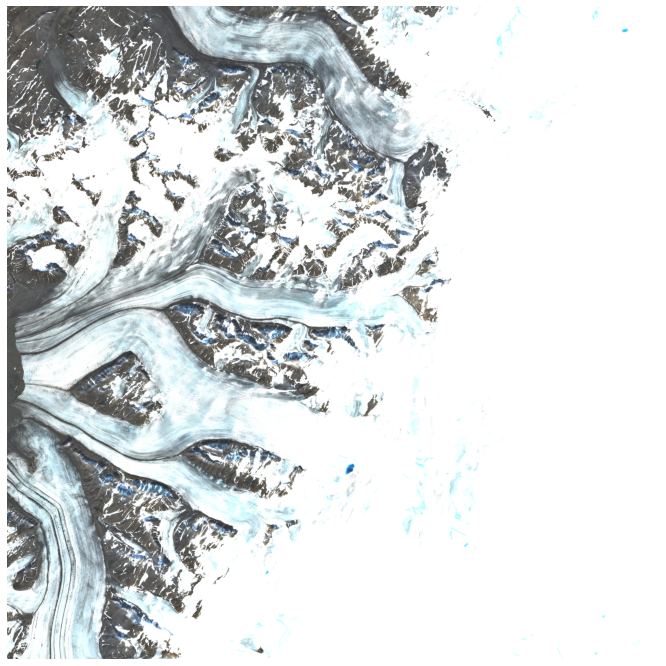

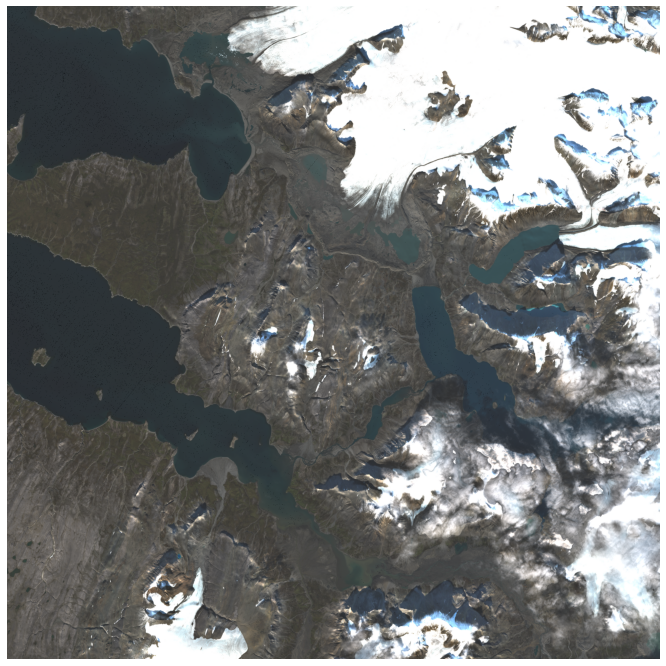

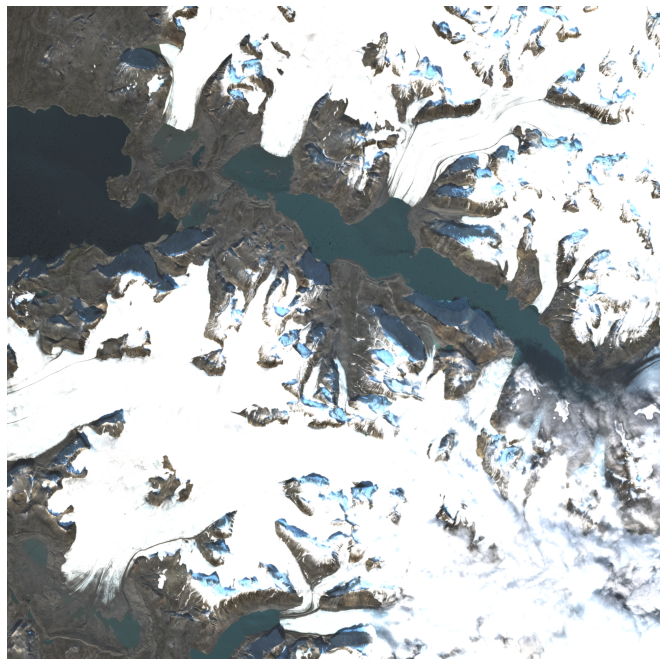

In [8]:
torch.manual_seed(1)

dataset = Sentinel2(root)
sampler = RandomGeoSampler(dataset, size=4096, length=3)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample)
    plt.axis("off")
    plt.show()

For those who are curious, these are glaciers on Novaya Zemlya, Russia.

## Custom parameters

If you want to add custom parameters to the class, you can override the `__init__` method. For example, let's say you have imagery that can be automatically downloaded. The `RasterDataset` base class doesn't support this, but you could add support in your subclass. Simply copy the parameters from the base class and add a new `download` parameter.

In [9]:
class Downloadable(RasterDataset):
    def __init__(self, root, crs, res, transforms, cache, download=False):
        super().__init__(root, crs, res, transforms, cache)

        if download:
            # download the dataset
            ...

## Contributing

TorchGeo is an open source ecosystem built from the contributions of users like you. If your dataset might be useful for other users, please consider contributing it to TorchGeo! You'll need a bit of documentation and some testing before your dataset can be added, but it will be included in the next minor release for all users to enjoy. See the [Contributing](https://torchgeo.readthedocs.io/en/stable/user/contributing.html) guide to get started.